# Calculating cost surfaces using weighted overlay analysis

This sample calculates a generic travel-cost surface for land animal populations migrating to new regions in response to climate change.  The parameters used in this analysis are slope, elevation, and level of human modification to the terrain.  

## Weighted overlay analysis
The weighted overlay is a standard GIS analysis technique often used for solving multicriteria problems such as generating surfaces representing site-suitability and travel-cost. Weighted overlay is used when a number of factors of variying importance should be considered to arrive at a final decision. This sample shows how raster anlaysis and raster arithmetic can be used to perform such analysis to solve spatial problems. The graphic below explains the logic behind weighted overlay, refer to this help for [a detailed information on weighted overlay analysis](http://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/how-weighted-overlay-works.htm)

![](http://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/GUID-D6D1FED1-18BA-4CFC-A056-498736B56C89-web.gif)

In the illustration, the two input rasters have been reclassified to a common measurement scale of 1 to 3. Each raster is assigned a percentage influence. The cell values are multiplied by their percentage influence, and the results are added together to create the output raster. For example, consider the upper left cell. The values for the two inputs become (2 * 0.75) = 1.5 and (3 * 0.25) = 0.75. The sum of 1.5 and 0.75 is 2.25. Because the output raster from Weighted Overlay is integer, the final value is rounded to 2. 

<blockquote>The example in this notebook is intended to serve only as a technology demo.  The specific analysis
shown here is not based on any known scientific research.</blockquote>

### Connect to GIS

In [1]:
# Connect to GIS
from arcgis.gis import GIS

gis = GIS('https://python.playground.esri.com/portal', 'arcgis_python', 'amazing_arcgis_123')
print("Successfully connected to {0} as {1}".format(gis.properties.name, gis.properties.user.username))

Successfully connected to Python Playground as arcgis_python


# Access the data for analysis

### Get area of interest using USA counties layer

<Item title:"USA Counties" type:Feature Layer Collection owner:esri_livingatlas>
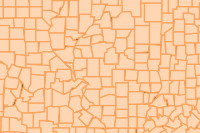

In [2]:
counties_item = gis.content.search('USA Counties', 'Feature Layer', sort_field='avgRating', outside_org=True)[0]
counties_item

In [3]:
counties = counties_item.layers[0]

We choose **Ventura** county in California as our study area for this sample.

In [10]:
qry = counties.query("NAME='Ventura'", return_geometry=True)

In [12]:
# Get the geometry of the Ventura county feature
geom_aoi = qry.features[0].geometry
geom_aoi['spatialReference'] = qry.spatial_reference

### DEM layer

In [13]:
# Get a reference to the DEM image service item
item_dem = gis.content.search('elevation_270m')[0]
item_dem

<Item title:"elevation_270m" type:Imagery Layer owner:arcgis_python>

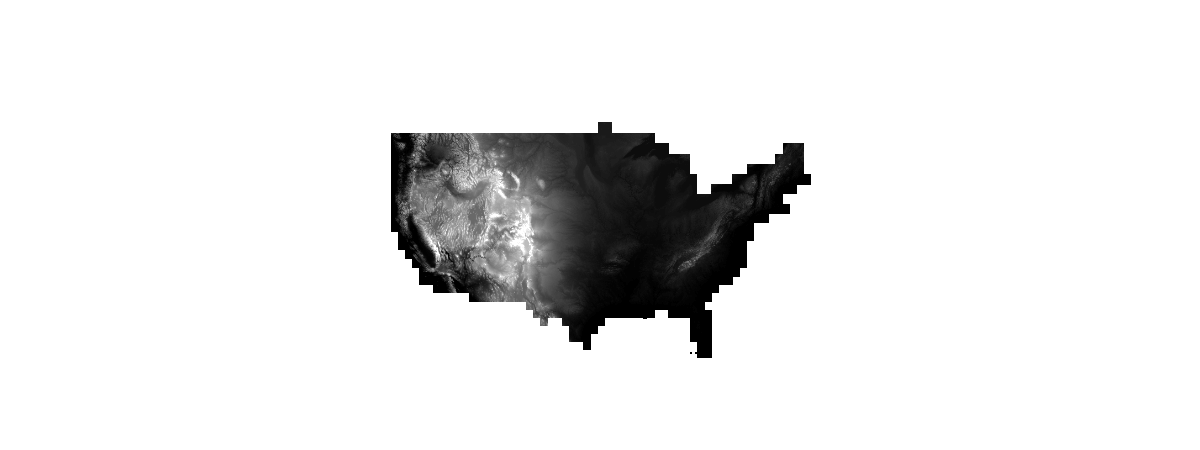

In [14]:
# Get a reference to the layer in the DEM image service item
lyr_dem = item_dem.layers[0]
lyr_dem

In [15]:
lyr_dem.properties.spatialReference

{
  "latestWkid": 3857,
  "wkid": 102100
}

In [16]:
# Import the geocode function from the API and get the location of Ventura County
from arcgis.geocoding import geocode
ventura_county = geocode('Ventura County', out_sr=lyr_dem.properties.spatialReference)[0]

#### Set the extent to match the area of interest

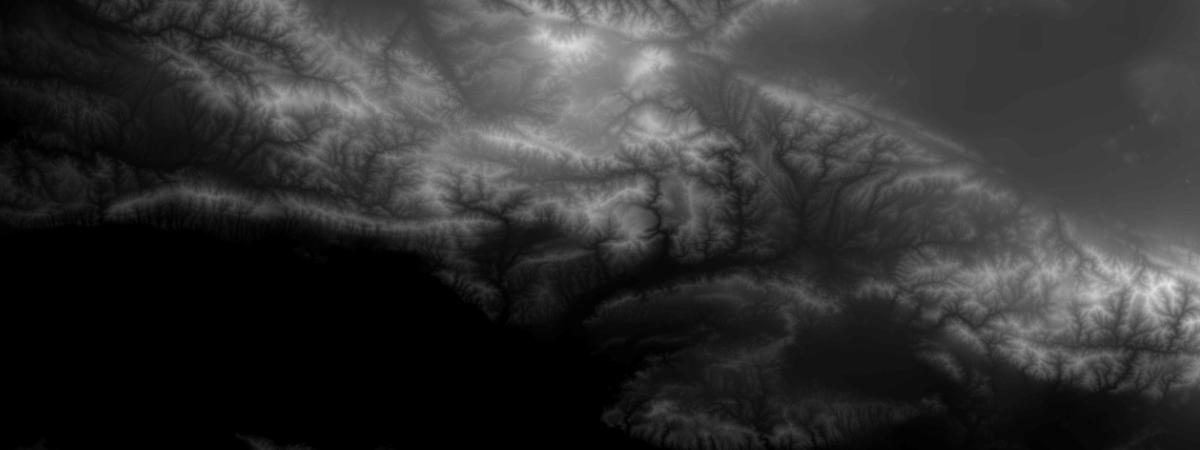

In [18]:
# Get a layer reference from the DEM image service item
# Display an exported image of the DEM layer with the bounding box set to Ventura County.
lyr_dem.extent = ventura_county['extent']
lyr_dem

### Slope analysis layer

In [19]:
# Import the raster functions from the API
from arcgis.raster.functions import *

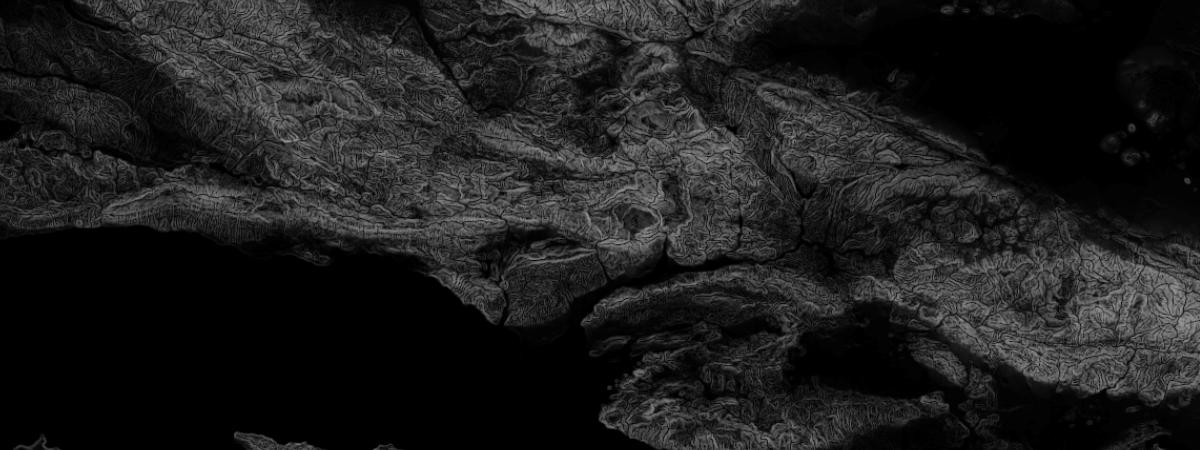

In [20]:
# Derive a slope layer from the DEM layer
lyr_slope = slope(dem=lyr_dem,slope_type='DEGREE', z_factor=1)
# Display an exported image of the slope layer with the bounding box set to Ventura County.
lyr_slope.extent= ventura_county['extent']
lyr_slope

### Human Modified Index analysis layer

In [21]:
# Get a reference to the Human Modified Index image service item.
# This dataset is based on research on the degree of human modification to the landscape, on a scale 
# of 0 - 1, where 0.0 indicates unmodified natural landscape and 1.0 indicates the landscape is 
# completely modified by human activity.

item_hmi = gis.content.search('human_modification_index')[0]
item_hmi

<Item title:"human_modification_index" type:Imagery Layer owner:arcgis_python>

In [22]:
lyr_hmi = item_hmi.layers[0]
lyr_hmi.properties.spatialReference

{
  "latestWkid": 3857,
  "wkid": 102100
}

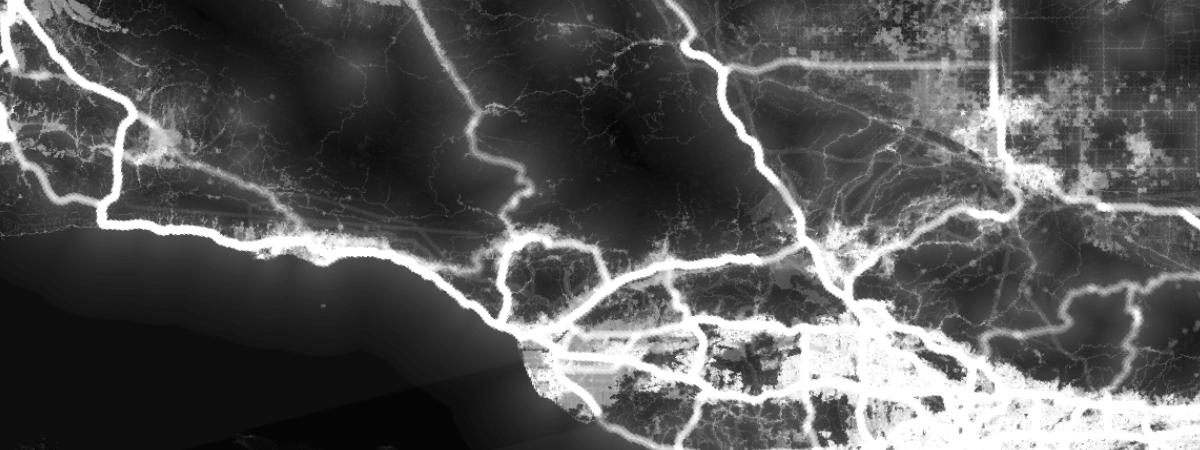

In [23]:
# Display an exported image of the HMI layer with the bounding box set to Ventura County.
lyr_hmi.extent = ventura_county['extent']
lyr_hmi

## Clip the analysis data to the geometry of the AOI

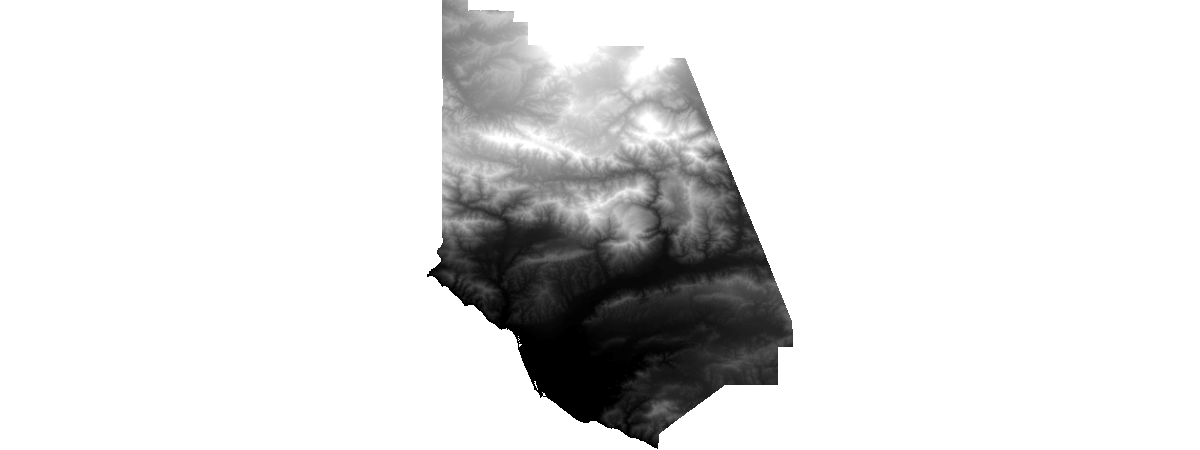

In [24]:
elev_clipped = clip(raster=lyr_dem, geometry=geom_aoi)
elev_clipped.extent= ventura_county['extent']
elev_clipped

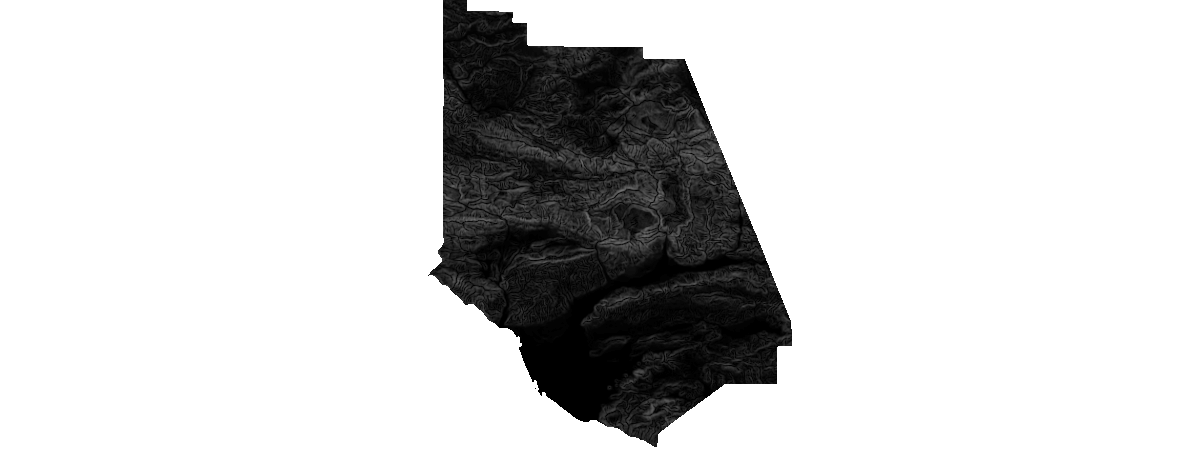

In [25]:
slope_clipped = slope(dem=elev_clipped, z_factor=1, ps_power=0.664, psz_factor=0.024, remove_edge_effect=False)
slope_clipped

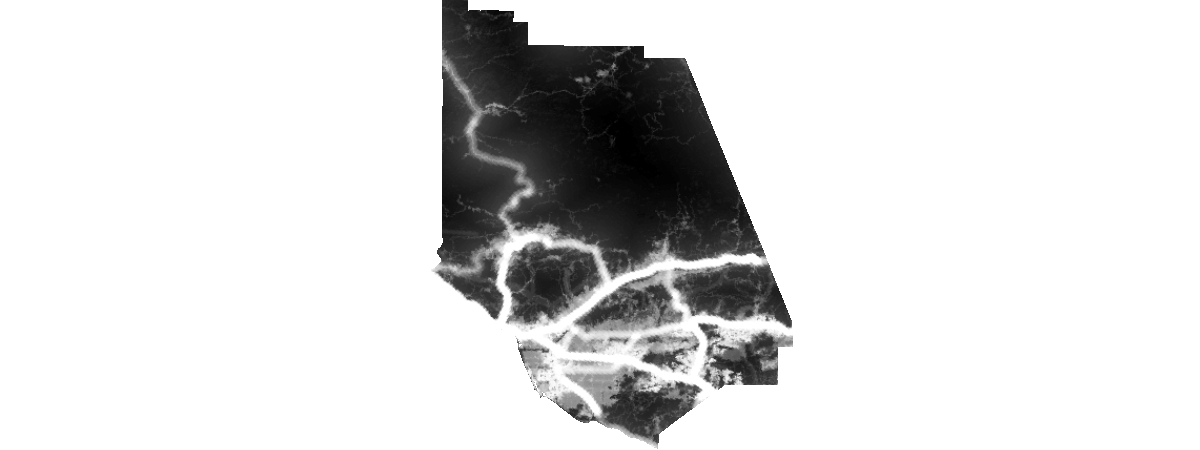

In [26]:
hmi_clipped = clip(raster=lyr_hmi, geometry=geom_aoi)
hmi_clipped

## Perform a weighted overlay analysis
We have gathered the different layers required for the analysis and clipped them to the same extent. Next we proceed by reclassifyig the rasters to a common scale.

### Reclassify the analysis datasets to a common scale of 1 - 9

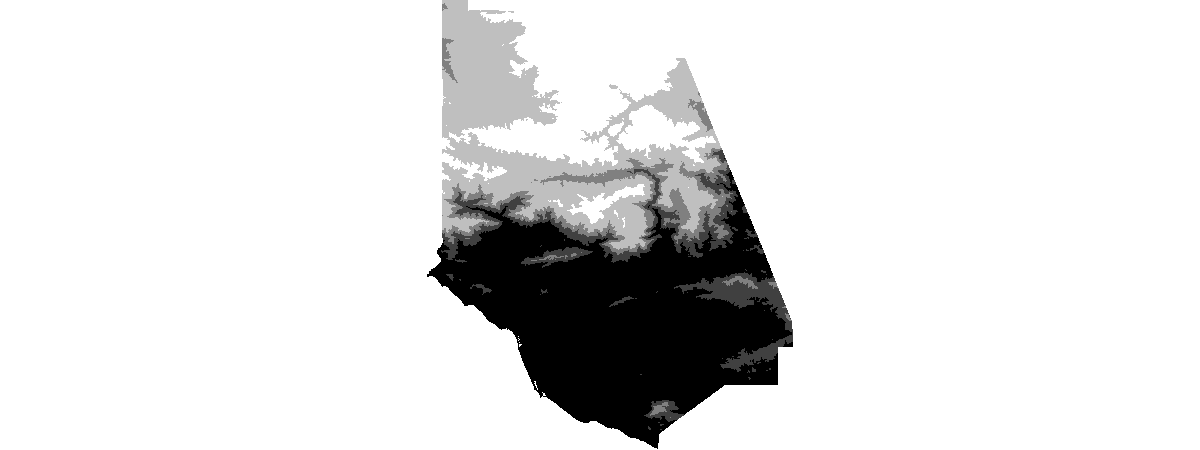

In [27]:
# Reclassify the elevation data to a scale of 1 - 9,
# where 1 = lowest elevation terrain that is therefore the easist to traverse,
# and 9 = highest elevation terrain that is the most difficult to traverse.
elev_remap = remap(raster=elev_clipped,
                       input_ranges=[-90,250, 250,500, 500,750, 750,1000, 1000,1500, 
                                     1500,2000, 2000,2500, 2500,3000, 3000,5000],
                       output_values=[1,2,3,4,5,6,7,8,9])
elev_remap

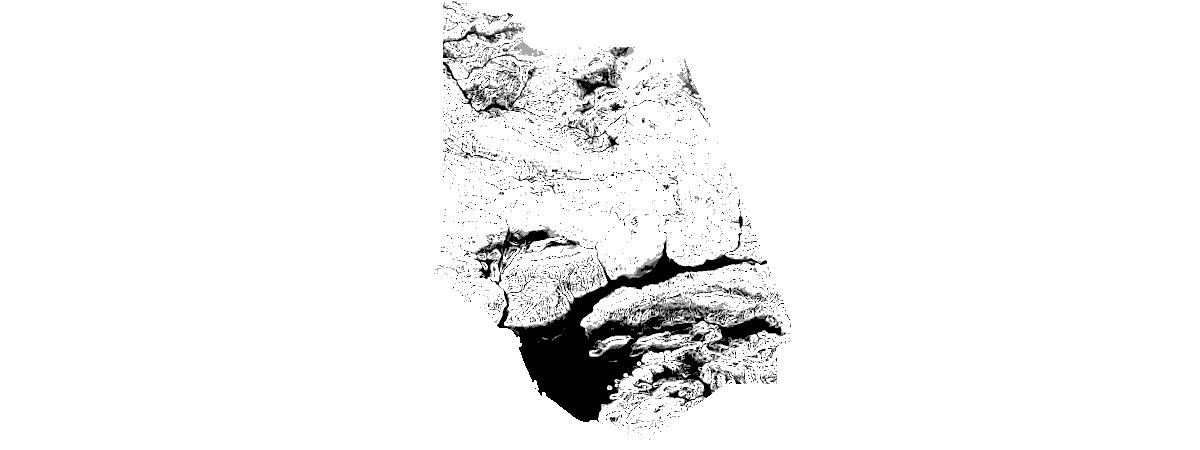

In [28]:
# Reclassify the slope data to a scale of 1 - 9, 
# where 1 = terrain that has the lowest slopes and is therefore thes easiest to traverse, 
# and 9 = terrain that has the highest slopes and is therefore the most difficult to traverse.
slope_remap = remap(raster=slope_clipped, 
                        input_ranges=[0,1, 1,2, 2,3, 3,5, 5,7, 7,9, 9,12, 12,15, 15,100],
                        output_values=[1,2,3,4,5,6,7,8,9]) 
slope_remap

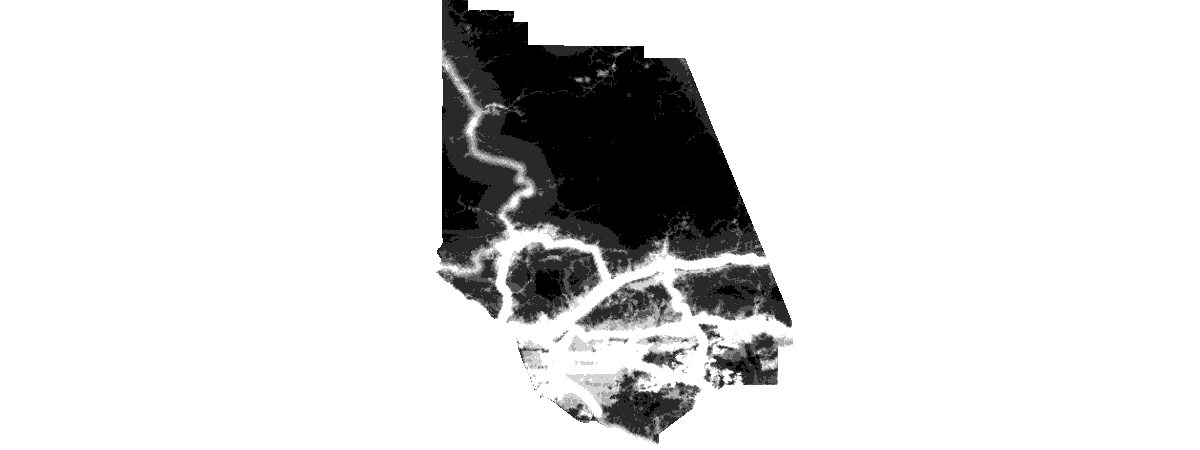

In [29]:
# Reclassify the Human Modified Index data to a scale of 1 - 9,
# where 1 = Terrain that is the least impacted by human activities 
# and is the easiest, or least hazardous to traverse,
# and 9 = terrain that is the most impacted by human activites
# and is therefore the most difficult or hazardous to traverse.
hmi_remap = remap(raster=hmi_clipped,
                  input_ranges=[0.0,0.1, 0.1,0.2, 0.2,0.3, 0.3,0.4, 0.4,0.5,
                                0.5,0.6, 0.6,0.7, 0.7,0.8, 0.8,1.1],
                  output_values=[1,2,3,4,5,6,7,8,9])
hmi_remap

### Display the reclassified data with a colormap

In [30]:
# Create a colormap for rendering the intermediate and final analysis results.
clrmap=  [[1,  38, 115,0],[2,  86, 148,0],[3,  0x8B, 0xB5,0],[4,  0xC5, 0xDB,0],
         [5, 255, 255, 0],[6,  0xFF, 0xC3,0],[7, 0xFA, 0x8E, 0],[8,  0xF2, 0x55,0],
         [9, 0xE6, 0, 0]]

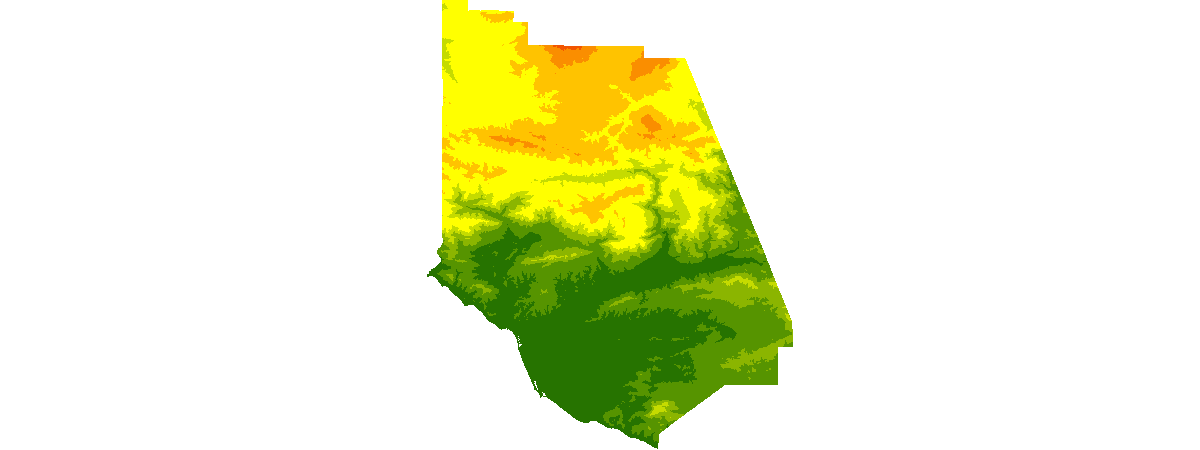

In [31]:
# Export an colormapped-image of the reclassified elevation data
colormap(elev_remap, colormap=clrmap)

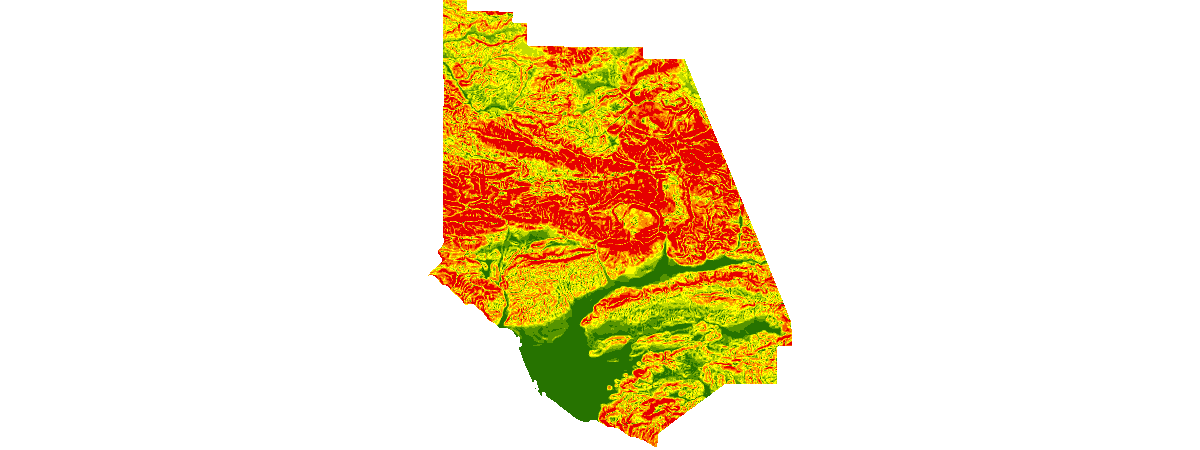

In [32]:
# Display a colormapped-image of the reclassified slope data
colormap(slope_remap, colormap=clrmap)

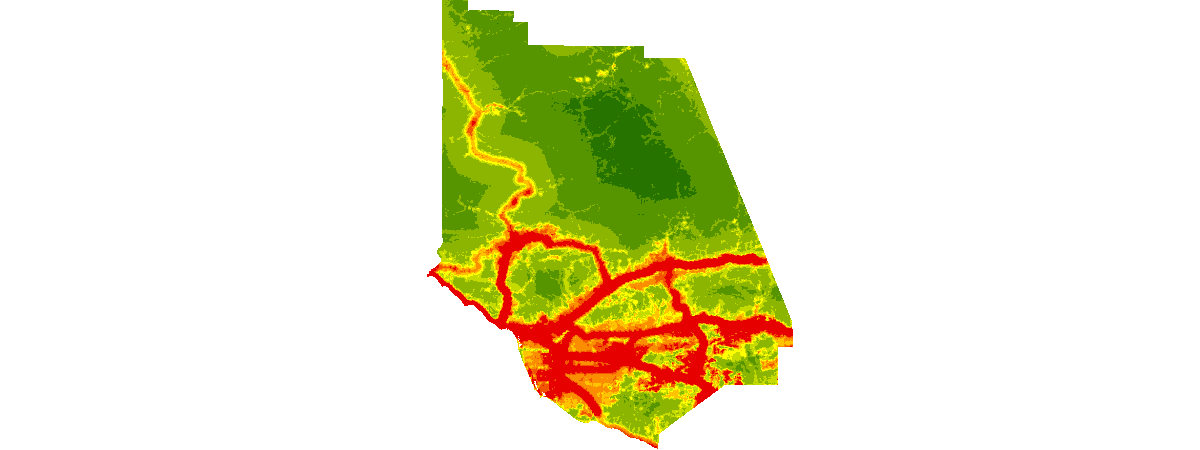

In [33]:
# Display a colormapped-image of the reclassified HMI data
colormap(hmi_remap, colormap=clrmap)

### Generate the final analysis output

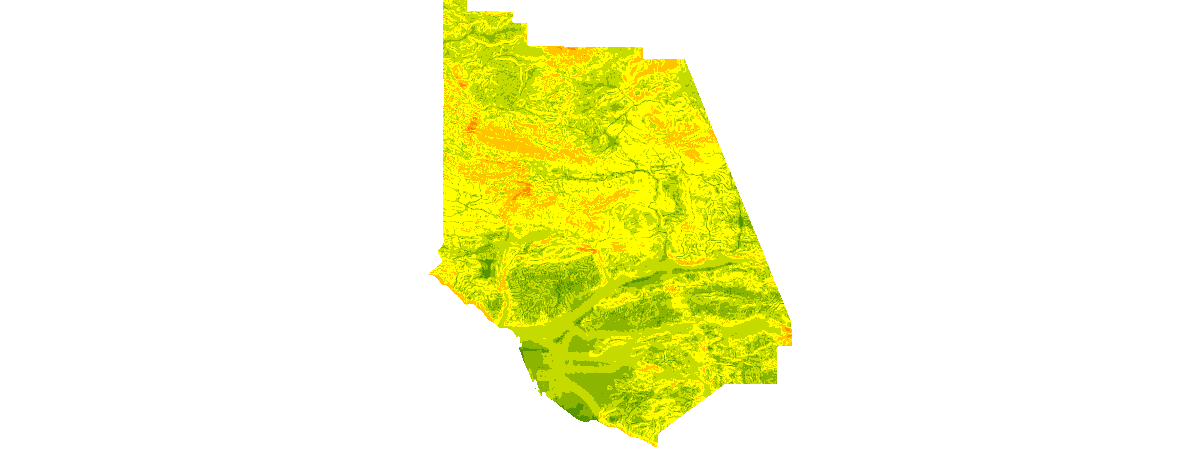

In [36]:
# Generate a final result using the intermediate datasets generated above:
#  - Apply weights to the reclassified datasets
#    - the sum of the weights must equal 1.0
#    - assign higher weight values to datasets that are considered to have more importance to the result
#  - Calculate the sum of the weighted, reclassified datasets (i.e. the weighted overlay)
#  - Display the result with a colormap, where red = high travel cost, and green = low travel cost

# In this example, each variable, elevation, slope, and HMI and given equal weight.
weighted_overlay = colormap(0.34 * elev_remap + 0.33 * slope_remap + 0.33 * hmi_remap, 
                              colormap=clrmap)
weighted_overlay

### Display the results on a map

In [38]:
# Display the result in a map
m = gis.map('Ventura County, USA')
m.add_layer(weighted_overlay)
m

### Save the result as an Imagery Layer

In [97]:
# Generate a persistent result at source resolution using Raster Analytics
import arcgis
arcgis.raster.analytics.is_supported(portal_gis)

True

In [98]:
from arcgis.raster.analytics import generate_raster

In [99]:
import arcgis.raster.analytics as ra
ra_result = weighted_overlay.save('WeightedOverlayResult_VenturaCounty')